In [1]:
from IPython.display import display, HTML

<div style="font-family: Arial, sans-serif; line-height: 1.6; font-size: 14px;">
    <h2 style="color: #2c3e50;">Sommaire</h2>
    <ol>
        <li>
            <b>Importation et Préparation des Données</b>
            <ul>
                <li>Base de données de la Ville de Marseille (2023)</li>
                <li>Données démographiques de l'INSEE (2024)</li>
                <li>Enrichissement des données et fusion des bases (2024)</li>
            </ul>
        </li>
        <li>
            <b>Analyse Exploratoire et Cartographie</b>
            <ul>
                <li>Informations de base sur les équipements et la population</li>
                <li>Analyse statistique descriptive des équipements canins</li>
                <li>Analyse géospatiale : localisation et distribution des équipements</li>
            </ul>
        </li>
        <li>
            <b>Accessibilité et Identification des Déserts Canins</b>
            <ul>
                <li>Recherche et définition des réglementations d’implantation</li>
                <li>Cartographie interactive des déserts canins par quartier</li>
            </ul>
        </li>
        <li>
            <b>Comparaison Nationale : Villes Amies des Chiens en 2024</b>
            <ul>
                <li>Analyse du classement 30 Millions d’Amis</li>
                <li>Création d'infographies comparatives</li>
            </ul>
        </li>
        <li>
            <b>Étude Comparative : Nice vs. Marseille</b>
            <ul>
                <li>Estimation et ratio chiens/habitants dans les deux villes</li>
                <li>Identification des déserts canins à Nice : cartes et analyses</li>
                <li>Visualisation des résultats : infographies et interprétations</li>
            </ul>
        </li>
    </ol>
</div>

In [3]:
# Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.stats import kruskal

import folium
from folium.plugins import MarkerCluster

from geopy.geocoders import Nominatim
from geopy.distance import geodesic

import ipywidgets as widgets
from IPython.display import display, clear_output
import geopandas as gpd

# 1. Importation et Préparation des Données

## Base de données de la ville de Marseille (publiée en 2023)
https://www.marseille.fr/sites/default/files/contenu/environnement/PDF/presence-des-chiens-dans-les-parcs-et-jardins-marseillais_v-28-04-23.pdf

- Arrondissements : arrd
- PARCS / JARDINS CENTRALISÉS : nom_jardin_parc
- ADRESSES : adresse
- ÉQUIPEMENTS : equipement
- ÉQUIPEMENTS : taille
- ÉQUIPEMENTS : date_creation

## Base de données de l'INSEE (publiée en 2024)
https://www.insee.fr/fr/statistiques/1405599?geo=COM-13201+COM-13202+COM-13203+COM-13204+COM-13205+COM-13206+COM-13207+COM-13208+COM-13209+COM-13210+COM-13211+COM-13212+COM-13213+COM-13214+COM-13215+COM-13216

- Population en 2021 : popu
- Densité de la population (nombre d'habitants au km²) en 2021 : densite_popu
- Superficie en 2021, en km² : superficie
- Nombre de ménages en 2021 : nombre_ menage
- Nombre total de logements en 2021 : nombre_total_logement
- Nombre de ménages fiscaux en 2021 : nombre_menage_fiscaux
- Médiane du revenu disponible par unité de consommation en 2021, en euros : mediane_revenu_dispo_unite_conso
- Taux de pauvreté en 2021, en % : taux_pauvrete
- Emploi total (salarié et non salarié) au lieu de travail en 2021 : emploi_total_au_lieu_travail
- Taux d'activité des 15 à 64 ans en 2021 : taux_activité_15_64
- Taux de chômage des 15 à 64 ans en 2021 : taux_chomage_15_64

## Enrichissement de la base de donnée

- Longitude : longitude
- Latitude : latitude

In [8]:
# Affichage du dataframe joint
data = pd.read_excel("Raw_data.xlsx")
data.head()

,indice,arrd,nom_jardin_parc,adresse,date_creation,latitude,longitude,equipement,taille,periode_de_lannee,...,densite_popu,superficie,nombre_ menage,nombre_total_logement,nombre_menage_fiscaux,mediane_revenu_dispo_unite_conso,taux_pauvrete,emploi_total_au_lieu_travail,taux_activité_15_64,taux_chomage_15_64
0,1,13004,Parc Longchamp,32 Bd du Jardin Zoologique,avant 2023,43.304683,5.395301,caniparc,6000,jamais interdit,...,17264.8,2.9,26115,29560,23815,20220,24,14818,73.1,15.5
1,2,13007,Jardin du Bois Sacré,Rue du Bois Sacré,avant 2023,43.282553,5.372271,caniparc,950,jamais interdit,...,5971.2,5.8,19554,22702,17888,26900,13,12798,76.4,9.7
2,3,13007,Jardin du Pharo-Émile Duclaux,58 Bd Charles Livon,prévu 2023,43.292232,5.359043,espace d’évolution canine,-1,jamais interdit,...,5971.2,5.8,19554,22702,17888,26900,13,12798,76.4,9.7
3,4,13007,Jardin de la Colline Puget,Rue Abbée d’Assy,avant 2023,43.289151,5.370147,caniparc,-1,jamais interdit,...,5971.2,5.8,19554,22702,17888,26900,13,12798,76.4,9.7
4,5,13007,Parc Central Bonneveine,271 Corniche Kennedy,prévu 2023/2024,43.279247,5.353536,caniparc,-1,jamais interdit,...,5971.2,5.8,19554,22702,17888,26900,13,12798,76.4,9.7


## Nettoyage de données / vérification des valeures manquantes

In [10]:
# je cherche les valeurs manquantes
print("\nMissing values per column:")
print(data.isna().sum())


Missing values per column:
indice                              0
arrd                                0
nom_jardin_parc                     0
adresse                             0
date_creation                       0
latitude                            0
longitude                           0
equipement                          0
taille                              0
periode_de_lannee                   0
popu                                0
densite_popu                        0
superficie                          0
nombre_ menage                      0
nombre_total_logement               0
nombre_menage_fiscaux               0
mediane_revenu_dispo_unite_conso    0
taux_pauvrete                       0
emploi_total_au_lieu_travail        0
taux_activité_15_64                 0
taux_chomage_15_64                  0
dtype: int64


# 2. Analyse Exploratoire et Cartographie
## Informations de base sur les équipements et la population

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   indice                            66 non-null     int64  
 1   arrd                              66 non-null     int64  
 2   nom_jardin_parc                   66 non-null     object 
 3   adresse                           66 non-null     object 
 4   date_creation                     66 non-null     object 
 5   latitude                          66 non-null     float64
 6   longitude                         66 non-null     float64
 7   equipement                        66 non-null     object 
 8   taille                            66 non-null     int64  
 9   periode_de_lannee                 66 non-null     object 
 10  popu                              66 non-null     int64  
 11  densite_popu                      66 non-null     float64
 12  superficie

In [13]:
demographic_cols = [
    'popu', 'densite_popu', 'superficie', 'nombre_ menage',
    'nombre_total_logement','nombre_menage_fiscaux',
    'mediane_revenu_dispo_unite_conso','taux_pauvrete',
    'emploi_total_au_lieu_travail','taux_activité_15_64','taux_chomage_15_64']

data[demographic_cols].describe()

,popu,densite_popu,superficie,nombre_ menage,nombre_total_logement,nombre_menage_fiscaux,mediane_revenu_dispo_unite_conso,taux_pauvrete,emploi_total_au_lieu_travail,taux_activité_15_64,taux_chomage_15_64
count,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000
mean,63719.090909,5738.096970,20.033333,29085.651515,32242.878788,26247.030303,21547.727273,23.727273,24005.984848,68.528788,14.612121
std,22142.585353,5415.179186,16.241687,9362.358124,10225.431919,8460.593107,4119.645166,11.016834,8907.445604,7.184894,4.070929
min,15487.000000,950.100000,2.100000,6877.000000,7760.000000,6595.000000,13530.000000,12.000000,8605.000000,53.400000,9.400000
25%,50829.750000,3278.600000,10.800000,24300.500000,27217.000000,20700.000000,19930.000000,13.500000,18313.000000,65.900000,10.025000
50%,63108.000000,4453.300000,16.400000,28862.000000,31068.000000,26804.000000,20440.000000,23.000000,21038.000000,69.800000,14.000000
75%,81870.750000,5443.000000,28.100000,38161.750000,41313.500000,34638.500000,25372.500000,27.000000,32458.500000,74.500000,17.000000
max,92261.000000,20428.800000,63.300000,42113.000000,48035.000000,37643.000000,27420.000000,52.000000,38261.000000,76.400000,21.400000


## 2.2 Analyse statistique descriptive des équipements canins

- Analyse de la répartition des équipements canins par arrondissement (compter, classer, répartition temporelle)
- Je veux comparer ces équipements aux données démographiques (population, densité, etc.)
- Je vais calculer des ratios plus pertinents (nb d’équipements/population)
- Je veux voir les arrondissements sous-équipés ou, au contraire, bien fournis
- Vérification de la qualité et la cohérence de mes données pour préparer les modèles plus poussés

### Quel est nombre d'équipements à Marseille tout arrondissement confondu ?

In [17]:
data.shape

(66, 21)

In [18]:
type_counts = data['equipement'].value_counts()
print("Répartition par type d'équipement :\n", type_counts)

Répartition par type d'équipement :
 equipement
non                          29
caniparc                     20
canisite                     10
espace d’évolution canine     7
Name: count, dtype: int64


### Combien de d'équipements pour chien (caniparc, canisite, espace d’évolution canine, non[éspace pour chien]) par arrondissement ?

In [20]:
equip_by_arr = data.groupby(['arrd', 'equipement'])['indice'].count()
equip_by_arr

arrd   equipement               
13003  caniparc                     2
13004  caniparc                     4
13005  canisite                     1
13006  caniparc                     1
       non                          1
13007  caniparc                     3
       espace d’évolution canine    1
       non                          1
13008  espace d’évolution canine    1
       non                          6
13009  caniparc                     3
       canisite                     1
       espace d’évolution canine    1
       non                          1
13010  caniparc                     4
       espace d’évolution canine    1
       non                          2
13011  non                          3
13012  caniparc                     1
       canisite                     2
       espace d’évolution canine    2
13013  canisite                     3
       espace d’évolution canine    1
       non                          6
13014  canisite                     1
       non       

On note également que les arrondissements 1 et 2 n'ont rien du tout.

### Quels arrondissements ont le plus grand nombre d’infrastructures canines, et lesquels en ont le moins ?

In [23]:
nombre_equipement_canin = data.groupby('arrd')['nom_jardin_parc'].count().sort_values(ascending=False)
print(nombre_equipement_canin)

arrd
13013    10
13008     7
13010     7
13009     6
13015     6
13007     5
13012     5
13016     5
13004     4
13011     3
13014     3
13003     2
13006     2
13005     1
Name: nom_jardin_parc, dtype: int64


On note également que les arrondissements 1 et 2 n'ont rien du tout.

**Top 3 :**
- 13e
- 8e
- 10e

**Bottom 3 :**
- 5e
- 1e
- 2e

### On veut voir si un arrondissement n’a qu'un (ou plusieurs) équipement en particulier

In [26]:
unique_types_by_arr = (
    data
    .groupby('arrd')['equipement']
    .apply(lambda x: set(x))  # convertit la colonne 'equipement' en ensemble unique
)

for arr, equip_set in unique_types_by_arr.items():
    if equip_set == {'caniparc'}:
        print(f"Arrondissement {arr} n'a que des caniparcs.")
    elif equip_set == {'canisite'}:
        print(f"Arrondissement {arr} n'a que des canisites.")
    elif equip_set == {'espace d’évolution canine'}:
        print(f"Arrondissement {arr} n'a que des éspaces d’évolution canine.")
    elif equip_set == {'non'}:
        print(f"Arrondissement {arr} n'a que des non (éspace non cloturé)")
print(f"Arrondissement 13001 n'a aucun équipement")
print(f"Arrondissement 13002 n'a aucun équipement")

Arrondissement 13003 n'a que des caniparcs.
Arrondissement 13004 n'a que des caniparcs.
Arrondissement 13005 n'a que des canisites.
Arrondissement 13011 n'a que des non (éspace non cloturé)
Arrondissement 13001 n'a aucun équipement
Arrondissement 13002 n'a aucun équipement


**En plus du fait que le 1e et 2e arrd n'a rien, il est problématique de voir que le 5e arrd n'a qu'un canisite (petit espace aménagé de 12 m² à 25 m²) alors qu'il possède aussi une des plus grande densité de population (nous allons voir ca plus bas).**

### Répartition temporelle

In [29]:
data.head()

,indice,arrd,nom_jardin_parc,adresse,date_creation,latitude,longitude,equipement,taille,periode_de_lannee,...,densite_popu,superficie,nombre_ menage,nombre_total_logement,nombre_menage_fiscaux,mediane_revenu_dispo_unite_conso,taux_pauvrete,emploi_total_au_lieu_travail,taux_activité_15_64,taux_chomage_15_64
0,1,13004,Parc Longchamp,32 Bd du Jardin Zoologique,avant 2023,43.304683,5.395301,caniparc,6000,jamais interdit,...,17264.8,2.9,26115,29560,23815,20220,24,14818,73.1,15.5
1,2,13007,Jardin du Bois Sacré,Rue du Bois Sacré,avant 2023,43.282553,5.372271,caniparc,950,jamais interdit,...,5971.2,5.8,19554,22702,17888,26900,13,12798,76.4,9.7
2,3,13007,Jardin du Pharo-Émile Duclaux,58 Bd Charles Livon,prévu 2023,43.292232,5.359043,espace d’évolution canine,-1,jamais interdit,...,5971.2,5.8,19554,22702,17888,26900,13,12798,76.4,9.7
3,4,13007,Jardin de la Colline Puget,Rue Abbée d’Assy,avant 2023,43.289151,5.370147,caniparc,-1,jamais interdit,...,5971.2,5.8,19554,22702,17888,26900,13,12798,76.4,9.7
4,5,13007,Parc Central Bonneveine,271 Corniche Kennedy,prévu 2023/2024,43.279247,5.353536,caniparc,-1,jamais interdit,...,5971.2,5.8,19554,22702,17888,26900,13,12798,76.4,9.7


In [30]:
dates = data['date_creation'].value_counts()
print(dates)

date_creation
avant 2023         59
prévu 2023/2024     4
prévu 2023          3
Name: count, dtype: int64


**7 équipements ont vu le jour entre 2023 et 2024 à Marseille.**

In [32]:
dates_arrd = data.groupby(['date_creation', 'arrd']).size()
print(dates_arrd)

date_creation    arrd 
avant 2023       13003    2
                 13004    4
                 13005    1
                 13006    1
                 13007    3
                 13008    7
                 13009    6
                 13010    6
                 13011    3
                 13012    5
                 13013    7
                 13014    3
                 13015    6
                 13016    5
prévu 2023       13007    1
                 13010    1
                 13013    1
prévu 2023/2024  13006    1
                 13007    1
                 13013    2
dtype: int64


- 6e = 1 nouveau équipement
- 7e = 2 nouveaux équipements
- 10e = 1 nouveau équipement
- 13e = 3 nouveaux équipements

**7 équipements ont vu le jour entre 2023 et 2024 dans le 6e, 7e, 10e et 13e arrondissements de Marseille.**

### Nombre d’équipements canins par arrondissement et question démographique

In [35]:
equip_demo_by_arr = (
    data
    .groupby('arrd')
    .agg(
        nb_equip=('equipement', 'count'),
        population=('popu', 'mean'),  # la popu est censée être la même pour l'arrondissement
        densite=('densite_popu', 'mean'),
        revenu_median=('mediane_revenu_dispo_unite_conso', 'mean'),
        taux_pauvrete=('taux_pauvrete', 'mean')
    )
    .reset_index()
)

display(equip_demo_by_arr)

,arrd,nb_equip,population,densite,revenu_median,taux_pauvrete
0,13003,2,53115.0,20428.8,13530.0,52.0
1,13004,4,50068.0,17264.8,20220.0,24.0
2,13005,1,45449.0,20289.7,20740.0,23.0
3,13006,2,39647.0,18879.5,24150.0,18.0
4,13007,5,34633.0,5971.2,26900.0,13.0
5,13008,7,82609.0,4453.3,27420.0,12.0
6,13009,6,77106.0,1218.7,24450.0,15.0
7,13010,7,59002.0,5443.0,20440.0,23.0
8,13011,3,57924.0,1723.9,22400.0,19.0
9,13012,5,63108.0,4475.7,25680.0,13.0


In [36]:
# Ici il faut que j'ajoute à ce df les données pour les arrondissements 1 et 2 qui n'ont aucun équipement
data_missing_values = pd.read_excel('Raw_data_missing_values.xlsx')
data_missing_values.head()

,indice,arrd,popu,densite_popu,superficie,nombre_ menage,nombre_total_logement,nombre_menage_fiscaux,mediane_revenu_dispo_unite_conso,taux_pauvrete,emploi_total_au_lieu_travail,taux_activité_15_64,taux_chomage_15_64
0,1,13001,39436,21908.9,1.8,21208,24116,15601,16530,38,23251,61.1,19.3
1,2,13002,23627,7687.9,5.0,1228,16153,10651,16390,39,25515,19.3,15.9


In [37]:
# je renome les colonnes
data_missing_values = data_missing_values.rename(
    columns={
        'popu': 'population',
        'densite_popu': 'densite',
        'mediane_revenu_dispo_unite_conso': 'revenu_median',
    })

In [38]:
# j'ajoute la colonne nombre d'équipements
data_missing_values['nb_equip'] = 0

In [39]:
# je liste les colonnes finales que je veux conserver
cols = ['arrd', 'nb_equip', 'population', 'densite', 'revenu_median', 'taux_pauvrete']

# On filtre
data_missing_values = data_missing_values[cols]
data_missing_values.head()

,arrd,nb_equip,population,densite,revenu_median,taux_pauvrete
0,13001,0,39436,21908.9,16530,38
1,13002,0,23627,7687.9,16390,39


In [40]:
# je joint les df
equip_demo_by_arr = pd.concat(
    [equip_demo_by_arr, data_missing_values],
    ignore_index=True)

# j'affiche
display(equip_demo_by_arr)

,arrd,nb_equip,population,densite,revenu_median,taux_pauvrete
0,13003,2,53115.0,20428.8,13530.0,52.0
1,13004,4,50068.0,17264.8,20220.0,24.0
2,13005,1,45449.0,20289.7,20740.0,23.0
3,13006,2,39647.0,18879.5,24150.0,18.0
4,13007,5,34633.0,5971.2,26900.0,13.0
5,13008,7,82609.0,4453.3,27420.0,12.0
6,13009,6,77106.0,1218.7,24450.0,15.0
7,13010,7,59002.0,5443.0,20440.0,23.0
8,13011,3,57924.0,1723.9,22400.0,19.0
9,13012,5,63108.0,4475.7,25680.0,13.0


### Visualiser la relation densité et nombre d’équipements

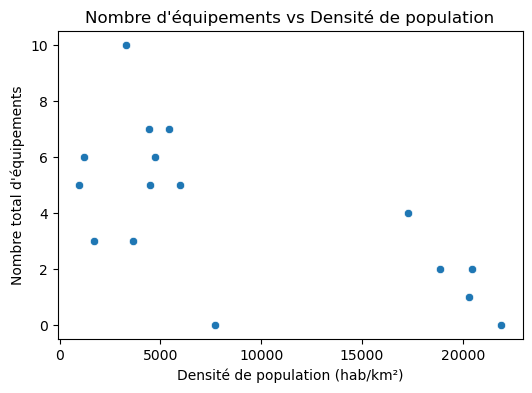

In [42]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=equip_demo_by_arr, x='densite', y='nb_equip')
plt.title("Nombre d'équipements vs Densité de population")
plt.xlabel("Densité de population (hab/km²)")
plt.ylabel("Nombre total d'équipements")
plt.show()

**On voit que les arrondissements 3, 4, 5 et 6, qui sont les plus denses possèdent le moins d'équipements, à savoir 2, 4, 1 et 2 respectivement, ce qui indiquerait un besoin critique.**

**A l'instar, les arrondissement moins dense 16, 11, 9 avec des équipements bien répartis spatialement pourrait ressortir comme suffisamment équipé par rapport à sa densité.**

### Calcule d'un ratio d’équipements pour 10 000 habitants

In [45]:
# On utilise la table equip_demo_by_arr créée juste en haut

equip_demo_by_arr['equip_per_10k'] = (
    equip_demo_by_arr['nb_equip'] / equip_demo_by_arr['population'] * 10000
)

# Classement du plus au moins équipé (corrigé par la population)
ratio_sorted = equip_demo_by_arr.sort_values('equip_per_10k', ascending=False)
display(ratio_sorted[['arrd', 'nb_equip', 'population', 'equip_per_10k']])

,arrd,nb_equip,population,equip_per_10k
13,13016,5,15487.0,3.228514
4,13007,5,34633.0,1.443710
7,13010,7,59002.0,1.186400
10,13013,10,92261.0,1.083882
5,13008,7,82609.0,0.847365
1,13004,4,50068.0,0.798913
9,13012,5,63108.0,0.792293
6,13009,6,77106.0,0.778150
12,13015,6,79656.0,0.753239
8,13011,3,57924.0,0.517920


**Le top 3** du nombre d'équipements par habitants (ces arrondissements sont mieux équipés, en tenant compte de sa population et non de la superficie de l'arrondissement[densité_popu]) :
- 16e = 3.23 équipement pour 10.000 habitants
- 7e = 1.44 équipement pour 10.000 habitants
- 10e = 1.19 équipement pour 10.000 habitants

**Les bottom** du nombre d'équipements par habitants :
- 6e & 14e = 0.5 équipement pour 10.000 habitants 
- 3e = 0.38 équipement pour 10.000 habitants
- 5e = 0.22 équipement pour 10.000 habitants
- 1e & 2e = 0 équipement pour 10.000 habitants

### Visualisation : relation entre les équipements et le revenu médian

Je vais créer des scatter plots pour voir la relation entre :

- Le revenu médian & le nombre d’équipements par densité en fonction de l'arrondissement
- Le taux de pauvreté & le nombre d’équipements par densité en fonction de l'arrondissement

In [48]:
# Calcul du ratio nb_equip / densite
equip_demo_by_arr['equip_per_density'] = (
    equip_demo_by_arr['nb_equip'] / equip_demo_by_arr['densite']
)

# voyons
equip_demo_by_arr.head(16)

,arrd,nb_equip,population,densite,revenu_median,taux_pauvrete,equip_per_10k,equip_per_density
0,13003,2,53115.0,20428.8,13530.0,52.0,0.376541,0.000098
1,13004,4,50068.0,17264.8,20220.0,24.0,0.798913,0.000232
2,13005,1,45449.0,20289.7,20740.0,23.0,0.220027,0.000049
3,13006,2,39647.0,18879.5,24150.0,18.0,0.504452,0.000106
4,13007,5,34633.0,5971.2,26900.0,13.0,1.443710,0.000837
5,13008,7,82609.0,4453.3,27420.0,12.0,0.847365,0.001572
6,13009,6,77106.0,1218.7,24450.0,15.0,0.778150,0.004923
7,13010,7,59002.0,5443.0,20440.0,23.0,1.186400,0.001286
8,13011,3,57924.0,1723.9,22400.0,19.0,0.517920,0.001740
9,13012,5,63108.0,4475.7,25680.0,13.0,0.792293,0.001117


### Revenu médian vs. équipements par densité

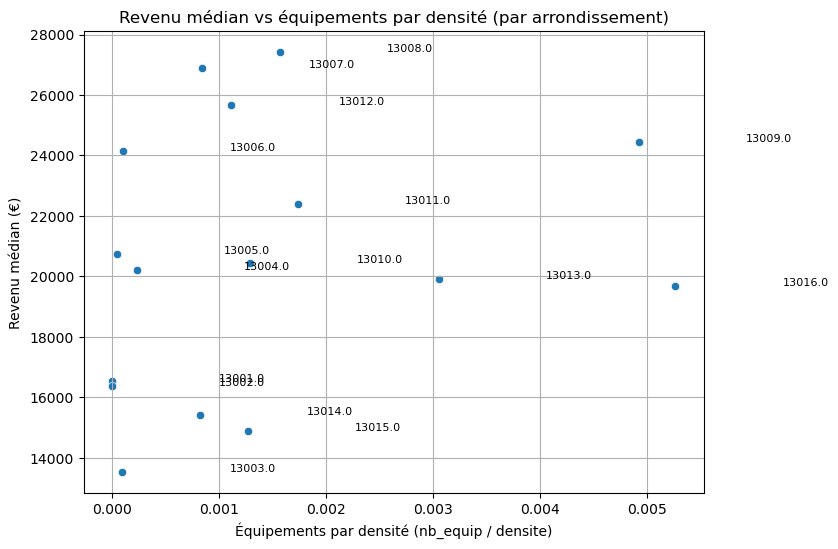

In [50]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=equip_demo_by_arr,
    x='equip_per_density',
    y='revenu_median'
)

# Annoter chaque point avec le numéro d'arrondissement
for i, row in equip_demo_by_arr.iterrows():
    plt.text(
        x=row['equip_per_density'] + 0.001,  # léger décalage pour lisibilité
        y=row['revenu_median'],
        s=str(row['arrd']), 
        fontsize=8
    )

plt.title("Revenu médian vs équipements par densité (par arrondissement)")
plt.xlabel("Équipements par densité (nb_equip / densite)")
plt.ylabel("Revenu médian (€)")
plt.grid(True)
plt.show()

**Interprétation :**

- Les arrondissements ayant un revenu médian moyen ont aussi tendance à avoir plus d’équipements par densité. On retrouve ici l'arrondissement 13, 16 et 9
- On voit un cluster en bas à gauche, ce qui montre peu d’équipements rapportés à la densité et un revenu médian faible. On retrouve les arrondissements 3, 15, 14, 1 et 2
- Le cluster en haut à gauche montre à l'instar un revenu médian élevé mais pas énorméments d'équipements par densitén même si légèrement supérieur au cluster du bas gauche du graphique

### Taux de pauvreté vs. équipements par densité

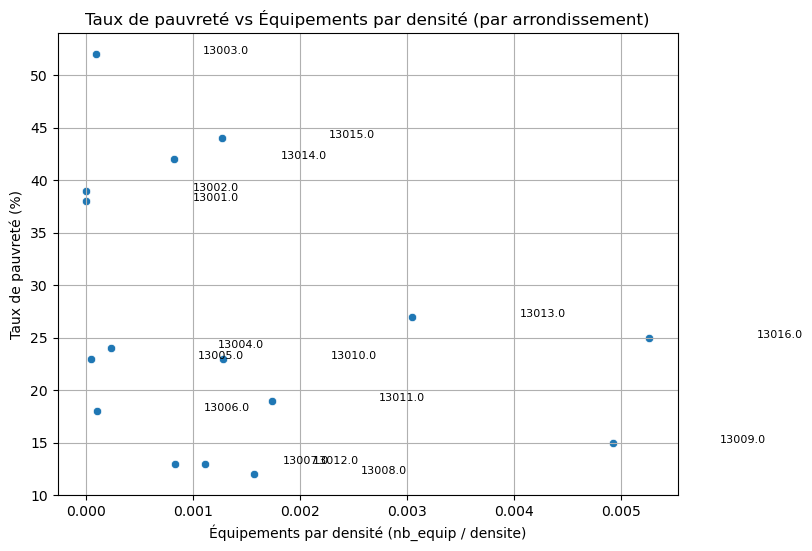

In [53]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=equip_demo_by_arr,
    x='equip_per_density',
    y='taux_pauvrete'
)

# Annoter chaque point
for i, row in equip_demo_by_arr.iterrows():
    plt.text(
        x=row['equip_per_density'] + 0.001,
        y=row['taux_pauvrete'],
        s=str(row['arrd']),
        fontsize=8
    )

plt.title("Taux de pauvreté vs Équipements par densité (par arrondissement)")
plt.xlabel("Équipements par densité (nb_equip / densite)")
plt.ylabel("Taux de pauvreté (%)")
plt.grid(True)
plt.show()

Les arrondissements avec un taux de pauvreté élevé (supérieur à 35%) à savoir le 3e, 15e, 14e, 1e et 2e ont peu d’équipements par densité.

**Je veux aller plus loin que les simples scatterplot pour savoir s'il existe une vrai corrélation entre le taux de pauvreté et les équipements disponibles.**

### Approche statistique pour mesurer la corrélation entre le taux de pauvreté et l'équipement par densité

Avec seulement 16 arrondissements, et des variables possiblement peu normales (taux de pauvreté, ratio équipements/densité…), je vais utiliser le test Spearman.
- H0: Pas de corrélation entre les deux variables : ρ = 0
- H1: Corrélation entre les deux variables : ρ ≠ 0

In [56]:

# je compare 'taux_pauvrete' et 'equip_per_density'

corr_spearman = pg.corr(
    equip_demo_by_arr['taux_pauvrete'],
    equip_demo_by_arr['equip_per_density'],
    method='spearman'
)
print(corr_spearman)

           n         r          CI95%     p-val     power
spearman  16 -0.341931  [-0.72, 0.19]  0.194882  0.260942


n : nombre d’observations (16)

r : coefficient de corrélation (-0.34 suggère une corrélation faible)

p-val : 0.19>0.05 donc ce n'est pas statistiquement significatif, et **je ne peux pas conclure avec certitude qu'il existe une relation entre le taux_pauvrete et l'equip_per_density.**

### Approche statistique pour mesurer la corrélation entre le revenu et l'équipement par densité en découpant en groupes de revenu (faible, moyen, élevé) 

Pour donner une analyse plus lisible je créer 3 groupes de revenu (faible, moyen, élevé) pour comparer les moyennes d’équipements dans chaque classe en utilisant ANOVA

In [59]:
# Découpe de la série 'revenu_median' en 3 catégories (faible, moyen, élevé)
equip_demo_by_arr['revenu_cat'] = pd.qcut(
    equip_demo_by_arr['revenu_median'],
    q=3,  # ducoup en 3 quantiles
    labels=['FaibleRevenu', 'MoyenRevenu', 'EleveRevenu']
)
display(equip_demo_by_arr[['arrd','revenu_median','revenu_cat']])

,arrd,revenu_median,revenu_cat
0,13003,13530.0,FaibleRevenu
1,13004,20220.0,MoyenRevenu
2,13005,20740.0,MoyenRevenu
3,13006,24150.0,EleveRevenu
4,13007,26900.0,EleveRevenu
5,13008,27420.0,EleveRevenu
6,13009,24450.0,EleveRevenu
7,13010,20440.0,MoyenRevenu
8,13011,22400.0,MoyenRevenu
9,13012,25680.0,EleveRevenu


In [60]:
anova_res = pg.anova(
    dv='equip_per_density',
    between='revenu_cat',
    data=equip_demo_by_arr,
    detailed=True
)
print(anova_res)

       Source            SS  DF            MS         F     p-unc       np2
0  revenu_cat  7.149717e-07   2  3.574859e-07  0.114116  0.893039  0.017253
1      Within  4.072467e-05  13  3.132667e-06       NaN       NaN       NaN


- p-valeur = 0.89 > 0.05

**Les différences observées entre les groupes ne sont pas statistiquement significatives.**

# 2.3 Exploration géospaciale

- Je veux afficher sur une carte les équipements canins
- Je veux calculer les distances entre des points d’intérêt (adresses, quartiers) et les parcs canins
- Je veux définir un seuil d’accessibilité (par exemple 800 m ou 1 km) pour repérer des déserts canins

### Visualisation sur une carte avec Folium

In [63]:
# je définis les arrondissements uniques à partir des données
arrondissements_uniques = sorted(data['arrd'].unique())  # Extraire et trier les arrondissements

# Générer une palette avec exactement autant de couleurs que d'arrondissements
palette = sns.color_palette("tab20", len(arrondissements_uniques)).as_hex()  # Palette pour couleurs distinctes
color_map = {arr: palette[i] for i, arr in enumerate(arrondissements_uniques)}  # Associer une couleur à chaque arrondissement

# Créer la carte
# Choix d'un point central approximatif sur Marseille (latitude, longitude)
marseille_center = [43.2965, 5.37]
m = folium.Map(location=marseille_center, zoom_start=12)

# Ajouter les points sur la carte
for i, row in data.iterrows():
    lat, lon = row['latitude'], row['longitude']
    arr = row['arrd']
    color = color_map[arr]
    folium.CircleMarker(
        location=[lat, lon],
        radius=8,  # Taille augmentée pour une meilleure visibilité
        color="black",  # Bordure noire pour contraster
        weight=1,  # Épaisseur de la bordure
        fill=True,
        fill_color=color,  # Couleur de remplissage
        fill_opacity=0.9,  # Opacité élevée pour que la couleur ressorte
        popup=f"Arr. {arr} - {row['nom_jardin_parc']} - {row['equipement']}"
    ).add_to(m)

# Ajouter une légende pour les couleurs des arrondissements
legend_html = """
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 250px;
    height: auto;
    background-color: white;
    border:2px solid grey;
    z-index:9999;
    font-size:14px;
    padding: 10px;
    ">
    <b>Couleurs des arrondissements</b><br>
"""
for arr, color in color_map.items():
    legend_html += f"<i style='background: {color}; width: 10px; height: 10px; display: inline-block;'></i> Arr. {arr}<br>"
legend_html += "</div>"

m.get_root().html.add_child(folium.Element(legend_html))

m

### Calcule de la distance d’une adresse donnée à chaque parc canin
le but étant qu'un utilisateur saisisse une adresse (texte) et obtienne la distance au parc canin le plus proche

#### Géocoder l’adresse
je peux utiliser geopy (service API) pour transformer l’adresse en latitude/longitude 

In [65]:
# Définition des fonctions qu'on va utilisées

geolocator = Nominatim(user_agent="my_app")

def get_coords_from_address(address):
    """
    Géocode l'adresse fournie et renvoie un tuple (latitude, longitude).
    Renvoie None si l'adresse n'est pas trouvée.
    """
    location = geolocator.geocode(address)
    if location:
        return (location.latitude, location.longitude)
    else:
        return None

def get_nearest_park(address, df):
    """
    Calcule le parc le plus proche de l'adresse spécifiée
    (dans un DataFrame df où chaque ligne = 1 parc).
    Retourne un tuple (park_name, distance_km).
    Retourne (None, None) si l'adresse n'est pas trouvée.
    """
    user_coords = get_coords_from_address(address)
    if not user_coords:
        return None, None
    
    min_distance = float('inf')
    nearest_park = None
    
    for i, row in df.iterrows():
        park_coords = (row['latitude'], row['longitude'])
        dist_km = geodesic(user_coords, park_coords).km
        if dist_km < min_distance:
            min_distance = dist_km
            nearest_park = row['nom_jardin_parc']
    
    return nearest_park, min_distance

def find_parks_within_radius(address, radius_km, df):
    """
    Retourne la liste des parcs situés à moins de radius_km km de l'adresse donnée.
    Chaque parc doit être défini par (latitude, longitude) dans df.
    
    Retourne un DataFrame filtré : df_in_radius
    """
    user_coords = get_coords_from_address(address)
    if not user_coords:
        return pd.DataFrame()  # vide si l'adresse n'a pas pu être géocodée
    
    results = []
    for i, row in df.iterrows():
        park_coords = (row['latitude'], row['longitude'])
        dist_km = geodesic(user_coords, park_coords).km
        if dist_km <= radius_km:
            # On retient le parc et la distance
            row_dict = row.to_dict()
            row_dict['distance_km'] = dist_km
            results.append(row_dict)
    
    df_in_radius = pd.DataFrame(results)
    # On peut trier par distance croissante
    df_in_radius = df_in_radius.sort_values('distance_km').reset_index(drop=True)
    return df_in_radius

#### Création du widget : Recherche des parcs à proximité

In [67]:
# 1. Champ texte
address_widget = widgets.Text(
    value='Le Rouet, Marseille',
    placeholder='Tapez une adresse',
    description='Adresse:',
    layout=widgets.Layout(width='300px')
)

# 2. Slider pour le rayon (en km)
radius_slider = widgets.FloatSlider(
    value=1.0, 
    min=0.1, 
    max=5.0, 
    step=0.1,
    description='Rayon (km):',
    continuous_update=False
)

# 3. Bouton
button_search = widgets.Button(
    description="Chercher parcs",
    button_style='success'
)

# 4. Zone de sortie
output_box_list = widgets.Output()

def on_button_search_clicked(b):
    with output_box_list:
        clear_output()
        address = address_widget.value
        radius = radius_slider.value
        df_parks = find_parks_within_radius(address, radius, data)
        
        if df_parks.empty:
            print(f"Aucun parc trouvé à moins de {radius:.1f} km de '{address}'")
        else:
            print(f"Parcs trouvés à moins de {radius:.1f} km de '{address}':")
            display(df_parks[['nom_jardin_parc','equipement','distance_km']])
        
button_search.on_click(on_button_search_clicked)

ui_part1 = widgets.VBox([
    widgets.HTML("<h4>Recherche des parcs à proximité</h4>"),
    address_widget,
    radius_slider,
    button_search,
    output_box_list
])

display(ui_part1)

#### Création du widget : Carte Folium : Parcs dans le rayon choisi

In [69]:
output_box_map = widgets.Output()

def on_button_search_map(b):
    with output_box_map:
        clear_output()
        address = address_widget.value
        radius = radius_slider.value
        df_parks = find_parks_within_radius(address, radius, data)
        
        user_coords = get_coords_from_address(address)
        if not user_coords:
            print("Adresse introuvable.")
            return
        
        # 1. Créer la carte centrée sur l'adresse de l'utilisateur
        m = folium.Map(location=user_coords, zoom_start=14)
        
        # 2. Marqueur de l'utilisateur
        folium.Marker(
            location=user_coords,
            popup=f"Adresse: {address}",
            icon=folium.Icon(color="red", icon="home")
        ).add_to(m)
        
        # 3. Ajouter un cercle autour de l'adresse (rayon = radius km => radius*1000 mètres)
        folium.Circle(
            location=user_coords,
            radius=radius*1000,
            color='blue',
            fill=True,
            fill_opacity=0.1,
            popup=f"Rayon {radius:.1f} km"
        ).add_to(m)
        
        # 4. Marqueurs des parcs trouvés
        if df_parks.empty:
            print(f"Aucun parc trouvé à moins de {radius:.1f} km.")
        else:
            for i, row in df_parks.iterrows():
                folium.Marker(
                    location=[row['latitude'], row['longitude']],
                    popup=f"{row['nom_jardin_parc']} ({row['distance_km']:.2f} km)",
                    icon=folium.Icon(color="green", icon="paw")
                ).add_to(m)
        
        # 5. Afficher la carte
        display(m)

button_search_map = widgets.Button(
    description="Afficher carte",
    button_style='info'
)

button_search_map.on_click(on_button_search_map)

ui_part2 = widgets.VBox([
    widgets.HTML("<h4>Carte Folium : Parcs dans le rayon choisi</h4>"),
    address_widget,
    radius_slider,
    button_search_map,
    output_box_map
])

display(ui_part2)

# 3. Définir un seuil d’accessibilité et repérer les déserts canins

## 3.1 Recherches et définition des réglementations

Au Québec au cours des dernières années, les demandes citoyennes pour l’aménagement de parcs canins se sont
accrues de façon significative. Cette situation va de pair avec les études canadiennes qui indiquent une croissance des ménages comptant au moins un chien. Compte tenu de cette popularité, plusieurs municipalités se sont penchées sur la question et ont défini **les règles d’implantation de parcs canins.** Ce sont ces données que nous exploitons.
https://terrebonne.ca/wp-content/uploads/2023/08/Guide_d_implantation_des_parcs_canins_VF2.pdf

Entre autre, on retrouves ces règles :
- Être situé à plus de 800 mètres (à vol d’oiseau) d’un autre parc canin

On peut interpréter cette donnée en lisant qu'il faut environ 800m dans une zone vide pour qu'un équipement canin soit présent. Pour convertir une distance à vol d'oiseau (800 mètres) en distance réelle en tenant compte des rues et du réseau piétonnier, on applique généralement un facteur de conversion. Ce facteur dépend de la configuration urbaine mais se situe souvent entre 1,2 et 1,5

Le temps de marche pour 800m serait donc :
- 12 à 18 minutes à un rythme tranquille (4km/h)
- 10 à 15 minutes à un rythme modéré (5km/h)

**On considère donc qu'un équipement doit se trouver dans un rayon de 800 mètres (à vol d’oiseau) depuis l'épicentre d'un quartier pour qu'il soit considéré comme accessible.**

Données relatives à la géolocalisation des quartiers de Marseille que je vais utiliser
https://www.data.gouv.fr/fr/datasets/quartiers-de-marseille-1/

In [74]:
# je charge les données géographiques des quartiers de Marseille
quartiers_geo = gpd.read_file("quartiers-marseille.geojson")

# calcule des centroïdes pour représenter chaque quartier par son épicentre
quartiers_geo['centroid'] = quartiers_geo.geometry.centroid
quartiers_geo['latitude'] = quartiers_geo['centroid'].y
quartiers_geo['longitude'] = quartiers_geo['centroid'].x

# je charge mes données d'équipements canins
equipements_data = data[['latitude', 'longitude', 'nom_jardin_parc', 'equipement']]

# fonction pour vérifier si un quartier a un équipement à moins de 800m
def has_equipement_within_radius(row, equipements_data, radius=0.8):
    quartier_coords = (row['latitude'], row['longitude'])
    for _, equip_row in equipements_data.iterrows():
        equip_coords = (equip_row['latitude'], equip_row['longitude'])
        distance = geodesic(quartier_coords, equip_coords).km
        if distance <= radius:  # vérifier si dans le rayon
            return True
    return False

# j'ajoute une colonne qui dit si un équipement est accessible
quartiers_geo['equipement_proche'] = quartiers_geo.apply(
    lambda row: has_equipement_within_radius(row, equipements_data), axis=1
)

# je filtre les quartiers sans équipement proche
quartiers_sans_equipement = quartiers_geo[quartiers_geo['equipement_proche'] == False]

# je montre le tableau des quartiers sans équipement proche
print("Quartiers sans équipement canin :")
print(quartiers_sans_equipement[['NOM_QUA', 'latitude', 'longitude']].to_string(index=False))


C:\Users\33758\AppData\Local\Temp\ipykernel_21144\860025878.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  quartiers_geo['centroid'] = quartiers_geo.geometry.centroid


Quartiers sans équipement canin :
           NOM_QUA  latitude  longitude
          BELSUNCE 43.299120   5.377013
          CHAPITRE 43.300545   5.384185
            THIERS 43.297214   5.384866
             ARENC 43.322633   5.357305
     GRANDS CARMES 43.301567   5.370983
    HOTEL DE VILLE 43.297079   5.367743
       LA JOLIETTE 43.303953   5.366410
      SAINT MAURON 43.316311   5.376496
NOTRE DAME DU MONT 43.292318   5.385423
           ENDOUME 43.276512   5.304034
      ROUCAS BLANC 43.275554   5.367953
        BONNEVEINE 43.254566   5.380438
        LES GOUDES 43.209820   5.365011
         MONTREDON 43.230770   5.365920
            PERIER 43.275857   5.380444
     LES BAUMETTES 43.223724   5.425356
         CARPIAGNE 43.249728   5.498803
         MAZARGUES 43.250005   5.405570
        LA PANOUSE 43.255131   5.432166
          LE REDON 43.230860   5.443789
           SORMIOU 43.222736   5.400318
         VAUFREGES 43.226961   5.480564
       SAINT TRONC 43.266531   5.434402
      

**Dans tous les quartiers ci dessus on retrouve des déserts canins (pas d'équipement canin a moins de 800m de son épicentre).**

## 3.2 Cartographie intéractives des déserts canins

In [77]:
# Créer une carte centrée sur Marseille
marseille_center = [43.2965, 5.3698]  # Coordonnées approximatives du centre de Marseille
m = folium.Map(location=marseille_center, zoom_start=12)

# Ajouter les quartiers sans équipements
for _, row in quartiers_sans_equipement.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"<b>Quartier :</b> {row['NOM_QUA']}<br><i>Aucun équipement à 800m</i>",
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

# Ajouter les quartiers avec équipements
quartiers_avec_equipement = quartiers_geo[quartiers_geo['equipement_proche'] == True]
for _, row in quartiers_avec_equipement.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"<b>Quartier :</b> {row['NOM_QUA']}<br><i>Équipement à 800m</i>",
        icon=folium.Icon(color='green', icon='ok-sign')
    ).add_to(m)

# Ajouter les équipements canins sur la carte
marker_cluster = MarkerCluster(name="Équipements canins").add_to(m)
for _, equip_row in equipements_data.iterrows():
    folium.Marker(
        location=[equip_row['latitude'], equip_row['longitude']],
        popup=f"<b>Équipement :</b> {equip_row['nom_jardin_parc']}",
        icon=folium.Icon(color='blue', icon='paw')
    ).add_to(marker_cluster)

# Ajouter une légende personnalisée
legend_html = """
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 250px;
    height: auto;
    background-color: white;
    border:2px solid grey;
    z-index:9999;
    font-size:14px;
    padding: 10px;
    ">
    <b>Légende</b><br>
    <i class="fa fa-map-marker" style="color:red"></i> Quartiers sans équipement à 800m<br>
    <i class="fa fa-map-marker" style="color:green"></i> Quartiers avec équipement à 800m<br>
    <i class="fa fa-map-marker" style="color:blue"></i> Équipements canins<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Afficher la carte
m

# 4. Où fait-il bon vivre avec son chien en France en 2024 ? 
https://www.30millionsdamis.fr/actualites/article/23651-palmares-des-villes-ou-il-fait-bon-vivre-avec-son-chien-quels-criteres/

42 villes, 6 critères, et un classement. Voilà 9 ans que le magazine 30 Millions d’amis publie son baromètre des villes de plus de 100 000 habitants en France où il fait bon vivre avec son chien.

## 4.1 Exploration des données

In [79]:
classement = pd.read_excel("classement_magazine_30million_damis.xlsx")
classement.head()

,rank_2024,ville,rank_2023,diff_rentiel,nombre_habitants,esp_verts,cani_parcs,transports,moy_accessibilite,proprete,sensibilisation,engagement,solidarite,chats_libres,moyenne_2024
0,1,LILLE,1,0,236234,12,17.0,5,11.3,16.7,15.0,16.7,20,15,16.2
1,2,NICE,2,0,343477,20,18.0,12,16.7,17.5,13.3,20.0,12,15,15.3
2,3,BORDEAUX,5,2,259809,20,18.0,20,19.3,11.7,15.0,11.3,18,5,14.7
3,4,MONTPELLIER,3,-1,299096,20,19.5,20,19.8,15.0,15.0,10.0,12,20,14.6
4,5,LIMOGES,10,5,130592,20,6.5,5,10.5,13.3,8.3,11.3,20,15,13.5


In [80]:
classement.loc[classement["ville"] == "MARSEILLE"]

,rank_2024,ville,rank_2023,diff_rentiel,nombre_habitants,esp_verts,cani_parcs,transports,moy_accessibilite,proprete,sensibilisation,engagement,solidarite,chats_libres,moyenne_2024
34,35,MARSEILLE,28,-7,870321,4,17.0,5,8.7,9.2,3.3,13.3,6,5,7.5


**Marseille est 35e dans ce classement. La ville est désendu de 7 positions entre 2023 et 2024 ce qui montre la nécessité d'agir.**

## 4.2 Infographies

## Visualisation 1 : Bar chart de la “moyenne_2024” (score global)

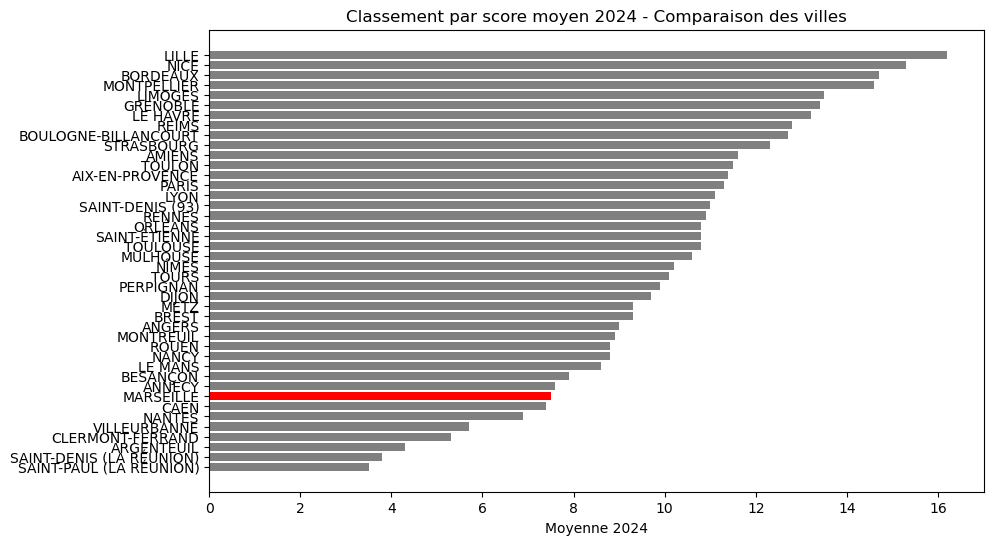

In [84]:
# Copie du DF pour le tri
df_sorted = classement.sort_values('moyenne_2024', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10,6))
colors = []
for i, row in df_sorted.iterrows():
    if row['ville'] == 'MARSEILLE':
        colors.append('red')  # Met Marseille en rouge
    else:
        colors.append('gray')

plt.barh(df_sorted['ville'], df_sorted['moyenne_2024'], color=colors)
plt.gca().invert_yaxis()  # Inverser l'axe Y pour voir la meilleure note en haut
plt.xlabel('Moyenne 2024')
plt.title("Classement par score moyen 2024 - Comparaison des villes")
plt.show()

## Visualisation 2 : Focus sur le “diff_rentiel” entre 2023 et 2024

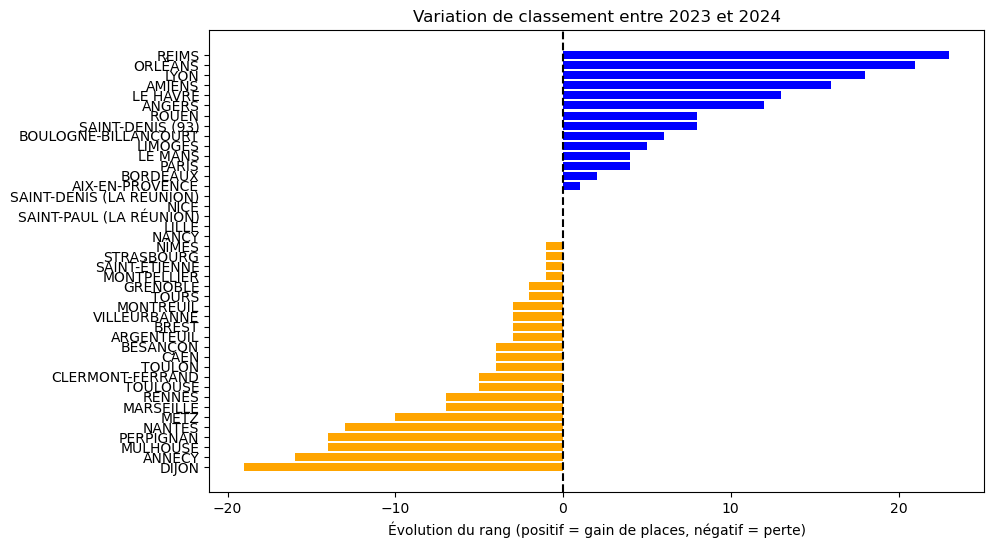

In [86]:
df_diff = classement[['ville','rank_2024','rank_2023','diff_rentiel']].copy()

# Bar chart montrant l'évolution (diff_rentiel)
# On mettra un code couleur (bleu si ascension, orange si descente)
df_diff = df_diff.sort_values('diff_rentiel', ascending=True)

colors = df_diff['diff_rentiel'].apply(lambda x: 'blue' if x>0 else ('gray' if x==0 else 'orange'))

plt.figure(figsize=(10,6))
plt.barh(df_diff['ville'], df_diff['diff_rentiel'], color=colors)
plt.axvline(0, color='black', linestyle='--')
plt.xlabel("Évolution du rang (positif = gain de places, négatif = perte)")
plt.title("Variation de classement entre 2023 et 2024")
plt.show()

## Visualisation 3 : Comparaison de différents critères pour un échantillon de villes (dont Marseille)

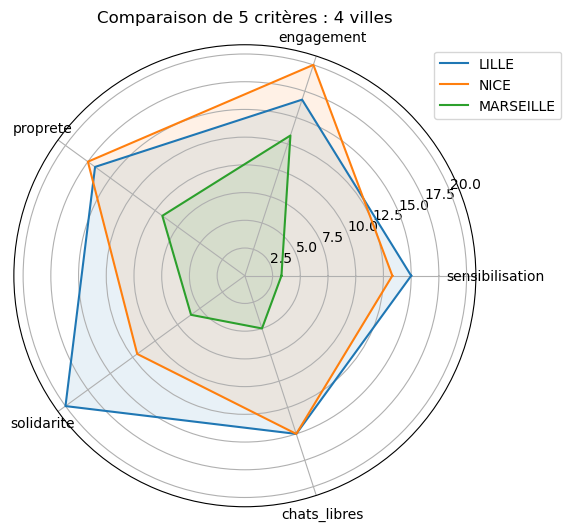

In [88]:
# Choisir les villes qu'on veut comparer
villes_cible = ["LILLE","NICE","MARSEILLE"]
criteria = ["sensibilisation", "engagement", "proprete", "solidarite", "chats_libres"]

df_comp = classement[classement['ville'].isin(villes_cible)].copy()
df_comp = df_comp.set_index('ville')[criteria]

# Préparer l'axe d'un radar chart
# On doit convertir la structure en lignes = ville, colonnes = variables
N = len(criteria)
angles = np.linspace(0, 2*np.pi, N, endpoint=False)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, polar=True)

for ville in villes_cible:
    values = df_comp.loc[ville].values
    # On boucle le tableau pour fermer le radar
    values = np.concatenate((values, [values[0]]))
    # Idem pour les angles
    angles2 = np.concatenate((angles, [angles[0]]))
    
    ax.plot(angles2, values, label=ville)
    ax.fill(angles2, values, alpha=0.1)

ax.set_thetagrids(angles * 180/np.pi, criteria)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title("Comparaison de 5 critères : 4 villes")
plt.show()

## Bar chart groupé

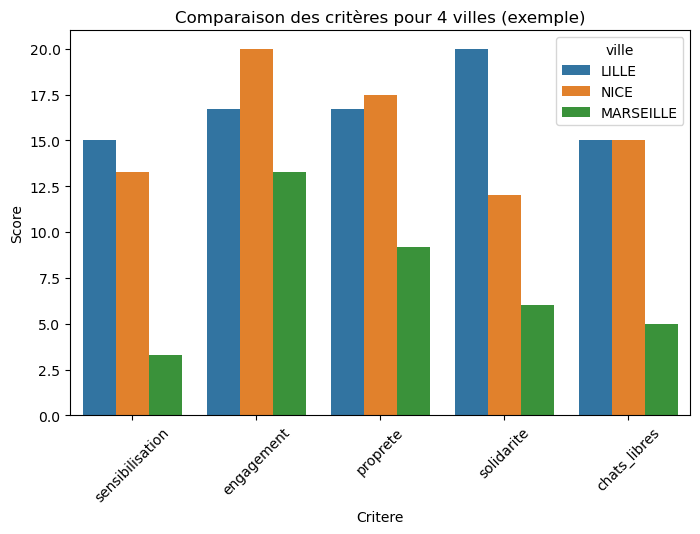

In [90]:
df_melt = df_comp.reset_index().melt(id_vars='ville', var_name='Critere', value_name='Score')

plt.figure(figsize=(8,5))
sns.barplot(data=df_melt, x='Critere', y='Score', hue='ville')
plt.title("Comparaison des critères pour 4 villes (exemple)")
plt.xticks(rotation=45)
plt.show()

## Visualisation 5 : Scatter plot (esp_verts vs. cani_parcs) + label Marseille

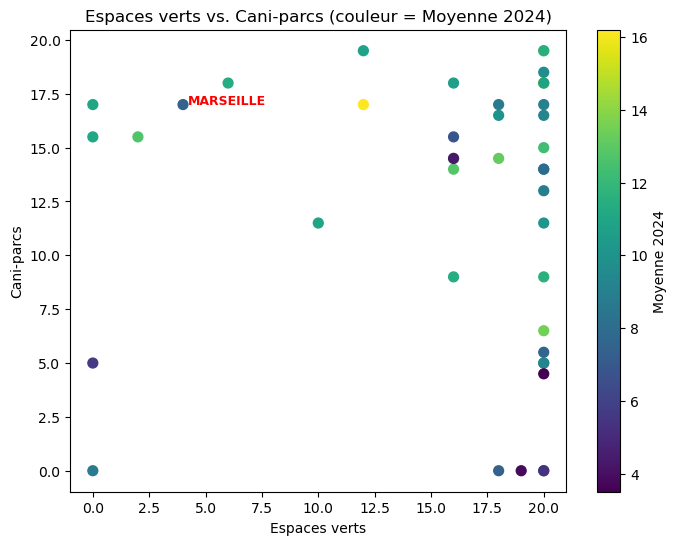

In [92]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    x=classement['esp_verts'],
    y=classement['cani_parcs'],
    c=classement['moyenne_2024'],  # couleur selon la moyenne
    cmap='viridis',
    s=50
)
plt.colorbar(scatter, label='Moyenne 2024')

plt.xlabel("Espaces verts")
plt.ylabel("Cani-parcs")
plt.title("Espaces verts vs. Cani-parcs (couleur = Moyenne 2024)")

# Annoter Marseille
row_marseille = classement.loc[classement['ville'] == 'MARSEILLE'].iloc[0]
plt.text(
    row_marseille['esp_verts']+0.2,
    row_marseille['cani_parcs'],
    "MARSEILLE",
    color='red',
    fontsize=9,
    fontweight='bold'
)

plt.show()

On constate pas mal de caniparcs mais très peu d'éspaces verts par rapport aux autres villes.
Dans le cluster en haut a gauche on voit quand même d'autres villes avec aussi peu d'éspaces verts mais autant de caniparcs, faisons un zoom sur ce cluster.

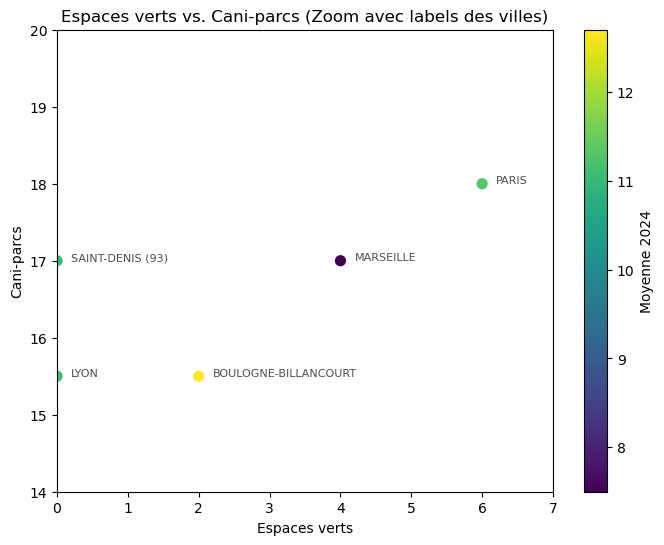

In [94]:
# filtre sur les villes dans la zone de zoom
df_zoom = classement[
    (classement['esp_verts'] >= 0) & (classement['esp_verts'] <= 7) &
    (classement['cani_parcs'] >= 14) & (classement['cani_parcs'] <= 20)
]

plt.figure(figsize=(8, 6))

# scatter plot sur le zoom
scatter = plt.scatter(
    x=df_zoom['esp_verts'],
    y=df_zoom['cani_parcs'],
    c=df_zoom['moyenne_2024'],  
    cmap='viridis',
    s=50
)
plt.colorbar(scatter, label='Moyenne 2024')

# axes et titres
plt.xlabel("Espaces verts")
plt.ylabel("Cani-parcs")
plt.title("Espaces verts vs. Cani-parcs (Zoom avec labels des villes)")

# mettre des labels pour les villes dans le zoom
for i, row in df_zoom.iterrows():
    plt.text(
        x=row['esp_verts'] + 0.2,
        y=row['cani_parcs'], 
        s=row['ville'], 
        fontsize=8,
        color='black',
        alpha=0.7
    )

plt.xlim(0, 7)
plt.ylim(14, 20)

plt.show()

In [95]:
villes_cibles = ["LYON", "SAINT-DENIS (93)", "MARSEILLE", "PARIS", "BOULOGNE-BILLANCOURT"]

# filtrer les villes dans le df
df_selection = classement[classement["ville"].isin(villes_cibles)]

# AFFICHER
df_selection.head()

,rank_2024,ville,rank_2023,diff_rentiel,nombre_habitants,esp_verts,cani_parcs,transports,moy_accessibilite,proprete,sensibilisation,engagement,solidarite,chats_libres,moyenne_2024
8,9,BOULOGNE-BILLANCOURT,15,6,120911,2,15.5,12,9.8,14.2,15.0,10.0,16,8,12.7
13,14,PARIS,18,4,2145906,6,18.0,12,12.0,5.0,15.0,10.0,10,15,11.3
14,15,LYON,33,18,522228,0,15.5,15,10.2,10.8,13.3,6.7,12,15,11.1
15,16,SAINT-DENIS (93),24,8,113116,0,17.0,12,9.7,15.0,11.7,10.0,10,13,11.0
34,35,MARSEILLE,28,-7,870321,4,17.0,5,8.7,9.2,3.3,13.3,6,5,7.5


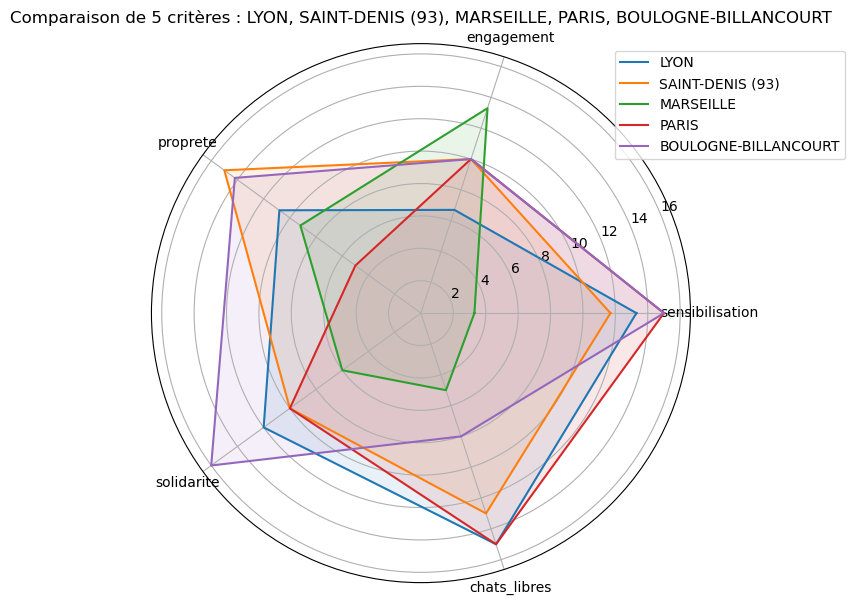

In [96]:
# séléction des nouvelles villes qu'on veut comparer
villes_cible = ["LYON", "SAINT-DENIS (93)", "MARSEILLE", "PARIS", "BOULOGNE-BILLANCOURT"]
criteria = ["sensibilisation", "engagement", "proprete", "solidarite", "chats_libres"]

# filtre sur les données pour les nouvelles villes
df_comp = classement[classement['ville'].isin(villes_cible)].copy()
df_comp = df_comp.set_index('ville')[criteria]

# Préparer l'axe pour le radar chart
N = len(criteria)
angles = np.linspace(0, 2*np.pi, N, endpoint=False)

fig = plt.figure(figsize=(7, 7))  # Taille légèrement augmentée pour mieux voir les détails
ax = fig.add_subplot(111, polar=True)

# Ajouter les données pour chaque ville
for ville in villes_cible:
    values = df_comp.loc[ville].values
    # Boucler pour fermer le radar
    values = np.concatenate((values, [values[0]]))
    angles2 = np.concatenate((angles, [angles[0]]))
    
    ax.plot(angles2, values, label=ville)
    ax.fill(angles2, values, alpha=0.1)

# Ajouter les labels pour chaque critère
ax.set_thetagrids(angles * 180/np.pi, criteria)

# Ajouter la légende et le titre
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.title("Comparaison de 5 critères : LYON, SAINT-DENIS (93), MARSEILLE, PARIS, BOULOGNE-BILLANCOURT")
plt.show()

## Comparaison avec le nombre d'habitants par ville (top 5)

In [98]:
classement_tri = classement.sort_values(by="nombre_habitants", ascending=False)
classement_tri.head()

,rank_2024,ville,rank_2023,diff_rentiel,nombre_habitants,esp_verts,cani_parcs,transports,moy_accessibilite,proprete,sensibilisation,engagement,solidarite,chats_libres,moyenne_2024
13,14,PARIS,18,4,2145906,6,18.0,12,12.0,5.0,15.0,10.0,10,15,11.3
34,35,MARSEILLE,28,-7,870321,4,17.0,5,8.7,9.2,3.3,13.3,6,5,7.5
14,15,LYON,33,18,522228,0,15.5,15,10.2,10.8,13.3,6.7,12,15,11.1
19,20,TOULOUSE,13,-5,498003,20,18.0,5,14.3,15.0,13.3,10.0,6,10,10.8
1,2,NICE,2,0,343477,20,18.0,12,16.7,17.5,13.3,20.0,12,15,15.3


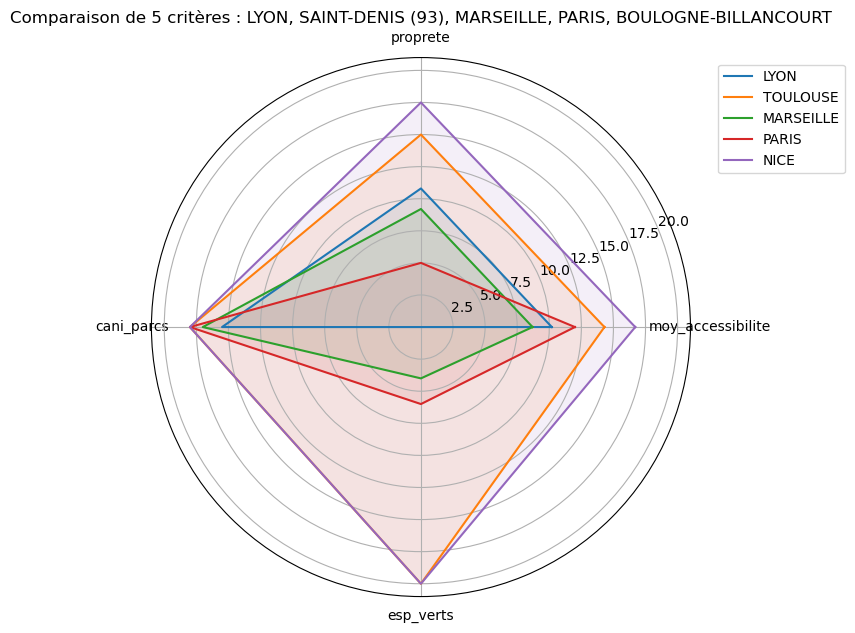

In [99]:
# séléction des nouvelles villes qu'on veut comparer
villes_cible = ["LYON", "TOULOUSE", "MARSEILLE", "PARIS", "NICE"]
criteria = ["moy_accessibilite", "proprete", "cani_parcs", "esp_verts"]

# filtre sur les données pour les nouvelles villes
df_comp = classement[classement['ville'].isin(villes_cible)].copy()
df_comp = df_comp.set_index('ville')[criteria]

# Préparer l'axe pour le radar chart
N = len(criteria)
angles = np.linspace(0, 2*np.pi, N, endpoint=False)

fig = plt.figure(figsize=(7, 7))  # Taille légèrement augmentée pour mieux voir les détails
ax = fig.add_subplot(111, polar=True)

# Ajouter les données pour chaque ville
for ville in villes_cible:
    values = df_comp.loc[ville].values
    # Boucler pour fermer le radar
    values = np.concatenate((values, [values[0]]))
    angles2 = np.concatenate((angles, [angles[0]]))
    
    ax.plot(angles2, values, label=ville)
    ax.fill(angles2, values, alpha=0.1)

# Ajouter les labels pour chaque critère
ax.set_thetagrids(angles * 180/np.pi, criteria)

# Ajouter la légende et le titre
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.title("Comparaison de 5 critères : LYON, SAINT-DENIS (93), MARSEILLE, PARIS, BOULOGNE-BILLANCOURT")
plt.show()

# 5. Compariason des villes Nice & Marseille

## 5.1 Calcule du nombre de chiens par habitant
Nombre de chiens enregistrés dans le fichier I-CAD et considérés comme vivants au 31/12/2022 en France par région

Sources : 
    - https://www.i-cad.fr/
    - https://www.ouest-france.fr/sciences/animaux/carte-votre-departement-est-il-plutot-chien-ou-plutot-chat-aba6bd20-06d9-11ee-84b8-578b00c238fa

In [103]:
nombre_chien_region = pd.read_excel('nombre_chien_region.xlsx')
nombre_chien_region.head()

,region,nombre_chien
0,Nord,382960
1,Ardennes,45538
2,Aisne,103657
3,Pas-de-Calais,309911
4,Somme,115207


Pour estimer le nombre de chiens à Marseille à partir des données des Bouches-du-Rhône (241 061 chiens enregistrés), j'utilise une approche proportionnelle basée sur la population humaine de Marseille par rapport à celle du département.

**Population des Bouches-du-Rhône :**
- 2 071 055 habitants (2023 source : Insee)

**Population de Marseille :**
- 870 731 habitants (2023 source : Insee)

Proportion = Population de Marseille/ Population des Bouches-du-Rhône ≈ 42%

**Estimation du nombre de chiens à Marseille = 241 061×0,4227 ≈ 101 852**

## Y-a-t-il plus de chiens par habitant à Marseille ou à Nice ?

- Nombre de chiens dans les Alpes-Maritimes : 130 811
- Population des Alpes-Maritimes : 1 114 579
- Population de Nice : 353 701

Estimation du nombre de chiens à Marseille = 241 061×0,4227 ≈ 101 852

Estimation du nombre de chiens à Marseille = 241 061×0,4227 ≈ 41 542

Calcule du ratio par habitant : Nombre estimé de chiens / population
- Nice ≈ 0,1175 chien/habitant (1 chien pour ~8,5 habitants)
- Marseille ≈ 0,1169 chien/habitant (1 chien pour ~8,5 habitants)

**Les ratios sont très proches ce qui montre qu’il y aurait à peu près autant de chiens par habitant dans les deux villes, avec un léger avantage pour Nice.**

## 5.2 Cartographie des déserts canins à Nice

In [107]:
# chemin vers le fichier GeoJSON sur mon ordinateur
file_path = r"C:\Users\33758\Documents\Data journalism Work\Parc à chiens\ev-equipement-opendata-2025.geojson.txt"

# je charge le fichier
data_geojson = gpd.read_file(file_path)

# regardons
data_geojson.head(50)

,NOM,IDENT,SOUS_TYPE,TYPE,DESIGNAT,geometry
0,Comte de Falicon (Nouveau Jardin),EV26_BA15770A_01,Canisite,Canide,None,POINT (7.25589 43.72952)
1,Phoenix (Parc),EV20_SF00590A_01,Eau brute recyclee,Fontaine,Fontaine centrale,POINT (7.21718 43.66858)
2,Ratti (Jardin de la Villa),EV26_AR00990A_01,Aire d'Ebat,Canide,None,POINT (7.27491 43.7103)
3,Scoffier (Jardin Paul),EV26_SS00130A_01,Aire d'Ebat,Canide,None,POINT (7.22049 43.67668)
4,Mont Boron (Foret Communale du),EV18_BA14550A_01,Sport,Jeux,None,POINT (7.30026 43.69685)
5,Mont Boron (Foret Communale du),EV18_BA14550A_02,Sport,Jeux,None,POINT (7.30115 43.69644)
6,Mont Boron (Foret Communale du),EV18_BA14550A_03,Sport,Jeux,None,POINT (7.3016 43.69697)
7,Guillaud (Parc Docteur Jean),EV18_BA14780A_04,Sport,Jeux,None,POINT (7.24194 43.72716)
8,Guillaud (Parc Docteur Jean),EV18_BA14780A_05,Sport,Jeux,None,POINT (7.24237 43.72753)
9,Guillaud (Parc Docteur Jean),EV18_BA14780A_06,Sport,Jeux,None,POINT (7.24306 43.7266)


Type / SOUS_TYPE / Désignation / CODE_TYPE
- Canide / Aire d'Ebat / Aire d'ébats pour chien / EV26
- Canide / Canisite / Canisite / EV26
- Canide / Plage / Plage pour chiens / EV26

Les équipement en lien avec les chiens sont de type **"Canide"**

In [109]:
# Filtrer les lignes où le TYPE est "Canide"
df_canide = data_geojson[data_geojson["TYPE"] == "Canide"]

# Sauvegarder le DataFrame filtré pour référence future
filtered_path = "canide_data_nice.geojson"
df_canide.to_file(filtered_path, driver="GeoJSON")

# Créer une carte simple pour visualiser les emplacements des équipements "Canide"
import folium

# Centrer la carte sur Nice
m = folium.Map(location=[43.7031, 7.2661], zoom_start=12)

# Ajouter les équipements "Canide" sur la carte
for _, row in df_canide.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],  # Extraire les coordonnées
        popup=f"{row['DESIGNAT']} ({row['SOUS_TYPE']})",
        icon=folium.Icon(color="blue", icon="paw"),
    ).add_to(m)

# Afficher la carte
m

In [110]:
df_canide.head()

,NOM,IDENT,SOUS_TYPE,TYPE,DESIGNAT,geometry
0,Comte de Falicon (Nouveau Jardin),EV26_BA15770A_01,Canisite,Canide,None,POINT (7.25589 43.72952)
2,Ratti (Jardin de la Villa),EV26_AR00990A_01,Aire d'Ebat,Canide,None,POINT (7.27491 43.7103)
3,Scoffier (Jardin Paul),EV26_SS00130A_01,Aire d'Ebat,Canide,None,POINT (7.22049 43.67668)
31,Batterie du Cimetiere Russe (Jardin de la),EV26_AR006657A_01,Aire d'Ebat,Canide,None,POINT (7.21496 43.68002)
32,Carol de Roumanie (Parc),EV26_SC01180A_02,Aire d'Ebat,Canide,None,POINT (7.2296 43.68823)


In [111]:
# je charge mon fichier
quartiers_nice = gpd.read_file("nice_territoire.geojson.txt")

# S'assurer d'être en WGS84 (EPSG:4326) pour utiliser geodesic
quartiers_nice = quartiers_nice.to_crs(epsg=4326)

# Créer des colonnes lat/lon (centroïde) pour placer les marqueurs
quartiers_nice["centroid"] = quartiers_nice.geometry.centroid
quartiers_nice["latitude"] = quartiers_nice["centroid"].y
quartiers_nice["longitude"] = quartiers_nice["centroid"].x

C:\Users\33758\AppData\Local\Temp\ipykernel_21144\3870389021.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  quartiers_nice["centroid"] = quartiers_nice.geometry.centroid


In [112]:
# On reprend le GeoDataFrame filtré pour EV26
df_canide = gpd.read_file("canide_data_nice.geojson")  # Ex. filtré "EV26"
df_canide = df_canide.to_crs(epsg=4326)

# Ajouter des colonnes lat/lon pour usage Folium
df_canide["latitude"] = df_canide.geometry.y
df_canide["longitude"] = df_canide.geometry.x

In [113]:
RAYON_MAX = 0.8  # en km

def has_canine_equipment_within_radius(lat, lon, df_equips, rayon=0.8):
    """Retourne True si on trouve un équipement canin à moins de `rayon` km du point (lat, lon)."""
    point_coords = (lat, lon)
    for _, row in df_equips.iterrows():
        dist_km = geodesic(point_coords, (row["latitude"], row["longitude"])).km
        if dist_km <= rayon:
            return True
    return False

# Appliquer la fonction à chaque quartier
quartiers_nice["equipement_proche"] = quartiers_nice.apply(
    lambda row: has_canine_equipment_within_radius(
        row["latitude"], row["longitude"], df_canide, rayon=RAYON_MAX
    ),
    axis=1
)

In [114]:
quartiers_sans_equipement = quartiers_nice[quartiers_nice["equipement_proche"] == False]
quartiers_avec_equipement = quartiers_nice[quartiers_nice["equipement_proche"] == True]

In [115]:
m = folium.Map(location=[43.7034, 7.2663], zoom_start=12)  # Coordonnées approximatives de Nice

# Quartiers sans équipements (rouge)
for _, row in quartiers_sans_equipement.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"<b>Quartier :</b> {row.get('NOM_QUARTIER','Inconnu')}<br><i>Aucun équipement à {RAYON_MAX}km</i>",
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

# Quartiers avec équipements (vert)
for _, row in quartiers_avec_equipement.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"<b>Quartier :</b> {row.get('NOM_QUARTIER','Inconnu')}<br><i>Équipement à {RAYON_MAX}km</i>",
        icon=folium.Icon(color='green', icon='ok-sign')
    ).add_to(m)

# Ajouter les équipements canins sur la carte
marker_cluster = MarkerCluster(name="Équipements canins").add_to(m)
for _, equip_row in df_canide.iterrows():
    folium.Marker(
        location=[equip_row['latitude'], equip_row['longitude']],
        popup=f"<b>Équipement :</b> {equip_row.get('DESIGNAT','Inconnu')}<br>IDENT: {equip_row.get('IDENT','')}",
        icon=folium.Icon(color='blue', icon='paw')
    ).add_to(marker_cluster)

# Ajouter une légende personnalisée
legend_html = f"""
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 250px;
    height: auto;
    background-color: white;
    border:2px solid grey;
    z-index:9999;
    font-size:14px;
    padding: 10px;">
    <b>Légende</b><br>
    <i class="fa fa-map-marker" style="color:red"></i> Quartiers sans équipement à {RAYON_MAX}km<br>
    <i class="fa fa-map-marker" style="color:green"></i> Quartiers avec équipement à {RAYON_MAX}km<br>
    <i class="fa fa-map-marker" style="color:blue"></i> Équipements canins<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Afficher la carte
m

**On constate qu'à l'isntar de Marseille, tous les quartiers de Nice ont un équipement pour chien à moins de 800m à vol d'oiseau.**

## 5.3 Infographies